## **Análisis Calidad Gasolina - Repúlica Dominicana**

**Fecha:** Julio 2024

**Preparado por:** Rafael J. Mateo C.

**Contacto:** rmateo@squalitas.com

In [451]:
from pypdf import PdfReader, PdfWriter
from pypdf.errors import PdfStreamError
from ocrmypdf.exceptions import SubprocessOutputError
import os
import ocrmypdf
from tqdm import tqdm
from IPython.display import clear_output
import json
import pandas as pd
from typing import Callable, Generator
from datetime import datetime
from azure.core.credentials import AzureKeyCredential
from azure.core.exceptions import HttpResponseError
from azure.ai.formrecognizer import DocumentAnalysisClient
from io import BufferedReader
from dotenv import load_dotenv
from pathlib import Path
from dateutil.parser import parse, ParserError
import re
import traceback
from collections import defaultdict
from unidecode import unidecode
import numpy as np
import matplotlib.pyplot as plt

In [3]:
skip_files = []
files_with_error = []
processed_files = []

raw_dir = './files/raw'
tmp_dir = './files/tmp'
output_dir = './files/ocr'
json_dir = './files/json'
sample_dir = './files/sample'
log_dir = './var'

In [14]:
for dirname in [raw_dir, tmp_dir, output_dir, json_dir, log_dir]:
    if not os.path.exists(dirname):
        os.makedirs(dirname)

### **1. Preprocesamiento** 

#### **1.1. Eliminando Páginas que no contienen los datos numéricos de las pruebas**

El siguiente código elimina los arhivos que tengan cuatro páginas o menos, ya que estos son los reportes de las estaciones que no autorizaron la realización de los ensayos. También elimina las últimas dos páginas, las cuales solo contienen las imágenes de los ensayos y las firmas de los que realizaron el reporte.

In [46]:
for name in os.listdir(raw_dir):
    src = os.path.join(raw_dir, name)
    reader = PdfReader(src)
        
    if len(reader.pages) <= 4:
        skip_files.append(name)
        continue
    
    dest = os.path.join(tmp_dir, name)
    
    #Eliminar las últimas dos páginas, ya que son fotos y firmas
    for page_num in [reader.get_num_pages()-1,reader.get_num_pages()-2,0]:
        reader.remove_page(page_num)
    
    writer = PdfWriter(clone_from=reader)
    writer.write(dest)

/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in the trailer - assuming there is no previous xref table
/Prev=0 in

Un total de 130 archivos contienen cuatro páginas o menos, por lo que fueron omitidos para este análisis.

In [42]:
len(skip_files)

130

#### **1.2. Realizando OCR**

En la siguiente celda realizaremos un OCR a aquellos archivos que contienen más de 4 páginas. Los archivos PDFs con OCR son colocados en el directorio 'files/ocr' por si requieren ser consultados posteriormente.

In [77]:
import warnings

error_files = []
warning_files = []

for name in tqdm(os.listdir(tmp_dir), unit='file', desc='Files processed: '):
    
    #Omite los archivos que tienen cuatro páginas o menos
    if name in skip_files or os.path.exists(os.path.join(output_dir, name)):
        clear_output(wait=True)
        continue
    
    try:
        with warnings.catch_warnings(record = True) as w:
            
            warnings.simplefilter("always")
            #Realiza OCR
            ocrmypdf.ocr(os.path.join(tmp_dir, name),
                    os.path.join(output_dir, name),skip_text=True, language='spa', deskew=True)
            if w:
                raise w[-1].category(w[-1].message)
    
    except SubprocessOutputError as error:
        error_files.append({'file': name, 'error': error})
    
    except Warning as e:
        warning_files.append({'file': name, 'warning': e})
        
    clear_output(wait=True)

Files processed: 100%|██████████| 810/810 [1:33:18<00:00,  6.91s/file]


Solo un archivo procesado generó un error. Este se refiere al reporte "2023 03 047.pdf". Revisando el archivo manualmente, la razón del error se debe a que las primeras páginas del reporte ya están en texto y no escaneado. Como es solo un archivo, manualmente pueden eliminarse las primeras cuantro páginas para realizar el OCR a las tablas de los datos solamente, ya que estas si están escaneadas.

In [78]:
error_files

[{'file': '2023 03 047.pdf',
  'error': ocrmypdf.exceptions.SubprocessOutputError('Ghostscript PDF/A rendering failed')}]

#### **1.3. Eliminando Páginas**

Ahora procedemos a eliminar las páginas que no contengan tablas de datos. Estas páginas suelen contener portadas, resúmenes u otras informaciones no relevantes para este análisis. La forma de filtrar las páginas que nos interesan es identificando aquellas que tengan el texto "Test Report".

In [50]:

def remove_pages(compare_func: Callable, input_dir: str, output_dir: str) ->dict[str, dict|list]:

    results = {'deleted_pages':defaultdict(list), 'errors': {} }

    for name in tqdm(os.listdir(input_dir), unit='file', desc='Files processed: '):
        
        try:
            if not name.endswith('.pdf'):
                continue
            
            reader = PdfReader(os.path.join(input_dir, name))
            pages = list(reader.pages)
        
        except PdfStreamError as e:
            results['errors'][name] = e
            continue
        
        for i,page in enumerate(pages):   
            text = page.extract_text()
            
            if not compare_func(text):
    
                reader.remove_page(page, True)
                results['deleted_pages'][name].append(i+1)
                
        writer = PdfWriter(clone_from=reader)
        writer.write(os.path.join(output_dir, name))
    
    return results

In [26]:
def page_count(dirname: str) -> int:
    num_pages = 0
    for name in tqdm(os.listdir(dirname), unit='file', desc='Files processed: '):
    
        try:
            if not name.endswith('.pdf'):
                continue
            
            reader = PdfReader(os.path.join(dirname, name))
            num_pages += len(reader.pages)

        except PdfStreamError as e:
            continue
    return num_pages

In [27]:
results = remove_pages(lambda text: text.find("Test Report") >= 0, output_dir, tmp_dir)

Files processed: 100%|██████████| 810/810 [03:08<00:00,  4.30file/s]


A continuación se muestran las páginas eliminadas para cada archivo

In [28]:
results

{'deleted_pages': defaultdict(list,
             {'2023 03 140.pdf': [1, 2, 3, 4],
              '2023 03 034.pdf': [2],
              '2023 05 065.pdf': [1, 2, 3, 4],
              '2023 05 059.pdf': [1],
              '2023 02 030.pdf': [2],
              '2023 08 047.pdf': [1],
              '2023 03 021.pdf': [4],
              '2023 07 001.pdf': [1, 2, 3],
              '2023 05 112.pdf': [3, 4],
              '2023 03 037.pdf': [3],
              '2023 05 072.pdf': [1],
              '2023 08 051.pdf': [1, 2],
              '2023 04 088.pdf': [1, 3],
              '2023 04 089.pdf': [1, 2, 3, 4],
              '2023 03 036.pdf': [4],
              '2023 03 022.pdf': [3],
              '2023 05 107.pdf': [1, 2, 3, 4],
              '2023 06 007.pdf': [1],
              '2023 01 080.pdf': [3],
              '2023 06 003.pdf': [2],
              '2023 06 017.pdf': [1, 2, 3, 4],
              '2023 04 066.pdf': [1],
              '2023 05 076.pdf': [1],
              '2023 06 016.pdf

Debido a que usaremos un servicio de pago de Azure, limitaremos el análisis únicamente a las Gasolinas. Para esto, filtramos solamente las páginas que contienen la palabra "GASOLINA". En caso de requerirse los datos para el Gasoil, simplemente sería sustituir la palabra "GASOLINA" por "GASOIL".

In [44]:
results2 = remove_pages(lambda text: text.find("GASOLINA") >= 0, tmp_dir,'./files/sample')

Files processed: 100%|██████████| 810/810 [03:09<00:00,  4.28file/s]


A continuación se presentan las páginas que fueron eliminadas para cada archivo

In [48]:
results2

{'deleted_pages': defaultdict(list,
             {'2023 07 014.pdf': [4, 5],
              '2023 07 028.pdf': [4, 5],
              '2023 04 100.pdf': [4, 5],
              '2023 01 051.pdf': [3, 4],
              '2023 01 045.pdf': [3, 4],
              '2023 01 079.pdf': [2, 5],
              '2023 06 011.pdf': [4, 5],
              '2023 06 005.pdf': [4, 5],
              '2023 06 039.pdf': [4, 5],
              '2023 03 168.pdf': [4, 5],
              '2023 05 111.pdf': [4, 5],
              '2023 05 105.pdf': [4, 5],
              '2023 03 034.pdf': [1, 3, 4],
              '2023 03 008.pdf': [4],
              '2023 08 052.pdf': [4],
              '2023 05 065.pdf': [2],
              '2023 05 071.pdf': [4, 5],
              '2023 08 046.pdf': [4, 5],
              '2023 05 059.pdf': [3],
              '2023 02 025.pdf': [4, 5],
              '2023 02 031.pdf': [3, 4, 5],
              '2023 07 148.pdf': [4, 5],
              '2023 02 019.pdf': [4, 5],
              '2023 04 074.

Finalmente, contamos la cantidad de páginas de nuestra muestra que serán analizadas en Azure, las cuales totalizan 2,284

In [51]:
page_count('./files/sample')

Files processed: 100%|██████████| 810/810 [00:00<00:00, 1109.38file/s]


2284

### **2. Análisis de los Documentos**

#### **2.1. Análisis y Extracción**

En esta sección se estará enviando cada uno de los documentos al servicio de Azure y luego se procederá a extraer la información de estos.

In [203]:
class DataExtractor:
    """
    Esta clase tiene como propósito extraer los datos del 
    json devuelto por el servicio de Azure.
    """
    
    page_num = None
    key_value_pairs: list[dict] = []
    tables: list[dict] = []
    
    def __init__(self, data) -> None:
        self.key_value_pairs = data['key_value_pairs']
        self.tables = data['tables']
            
    def __filter_by_content_fn (self,page_num: int, keyword: str) -> Callable:
        
        return lambda item: re.search(keyword, item['key']['content'].lower()) is not None \
            and item['key']['bounding_regions'][0]['page_number'] == page_num

    
    def __filter_table(self, page_number: int) -> dict|None:
        results = list(filter(
            lambda table: table['bounding_regions'][0]['page_number'] == page_number, 
            self.tables))
        
        if len(results) == 0:
            return None
        
        return results[0]
    
    def __extract_headers(self, cells: list[dict]) -> list[str]:
        filtered_cells =  list(filter(lambda item: 'kind' in item and item['kind'] == 'columnHeader', cells ))
        headers = []
        
        for header in filtered_cells:
            # No nos interesan las columnas combinadas
            if 'column_span' in header and header['column_span'] >= 2:
                continue
            
            headers.insert(header['column_index'], header['content'])
  
        return headers
    
    def __extract_rows(self, cells: list[dict], columnCount: int) -> list[str|float|int]:
        filtered_cells = list(filter(lambda item: 'kind' in item and item['kind'] == 'content', cells))
        rows = []
        row = []
        
        for index,cell in enumerate(filtered_cells):
            
            if index >0  and (index % columnCount) == 0:
                
                rows.append(row)
                row = []
                
            row.insert(cell['column_index'], cell['content'])
            
        return rows
    
    def extract_client_name (self, page_number: int) -> str:
        
        results = list(filter(self.__filter_by_content_fn(page_number, r"cliente[\s|\/\\n]+client"), self.key_value_pairs))
        
        if len(results) == 0:
            return ''
        
        return results[0]['value']['content']
        
    def extract_test_date (self, page_number: int) -> datetime|str:
        results = list(filter(
            self.__filter_by_content_fn(page_number, r"date-time"), self.key_value_pairs))
        
        if len(results) == 0:
            return ''
        date = re.match(
            r"(\d{1,2}/\d{1,2}/\d{4}\s\d{1,2}:\d{2}(?:\s[ap]\.m)?)", 
            results[0]['value']['content'])[0]
        try:
            return parse(date)
        except ParserError:
            return parse(re.sub(r'p\.m|a\.m', '',date))
        
    def extract_product_name(self, page_number: int) -> str:
            
        results = list(filter(self.__filter_by_content_fn(page_number, 'producto'), self.key_value_pairs))
        
        if len(results) == 0:
            return ''
        
        return results[0]['value']['content']
    
    def extract_table(self, page_num:int) -> pd.DataFrame:
        table_items =  self.__filter_table(page_num)
        if table_items is None:
            return pd.DataFrame
        
        headers = self.__extract_headers(table_items['cells'])
        values = self.__extract_rows(
            table_items['cells'], len(headers))

        df = pd.DataFrame(values, columns=headers)
        
        return df.assign(
            CLIENTE = self.extract_client_name(page_num), 
            PRODUCTO = self.extract_product_name(page_num), 
            FECHA = self.extract_test_date(page_num))
    
    def extract_tables(self) -> pd.DataFrame:
        df = pd.DataFrame()
        
        for table in self.tables:
            df1 = self.extract_table(table['bounding_regions'][0]['page_number'])
            df1['NUM PAGINA'] = table['bounding_regions'][0]['page_number']
            df = pd.concat([df, df1], ignore_index=True)
            
        return df
    

In [131]:
class DocumentAnalyzer:
    """
    Esta clase se encarga de leer cada uno de los archivos
    en el directorio especificado y enviarlos al servicio de
    Azure
    """
    
    document_analysis_client: DocumentAnalysisClient|None = None
    processed_files: list[str] = []
    errors: list[dict[str,str|BaseException]] = []
    
    def __init__(self) -> None:
        
        load_dotenv(override=True)
        endpoint = os.environ["AZURE_FORM_RECOGNIZER_ENDPOINT"]
        key = os.environ["AZURE_FORM_RECOGNIZER_KEY"]
        
        self.document_analysis_client = DocumentAnalysisClient(
        endpoint=endpoint, credential=AzureKeyCredential(key)
    )
        
    def __file_reader(self,dirname: str) -> Generator[BufferedReader, None, None]:
        
        for name in tqdm(os.listdir(dirname), unit='file', desc='Files processed: '):
            with open(os.path.join(dirname, name), "rb") as f:
                yield f
    
    def __get_analysis(self, file: BufferedReader) -> dict[str, str]:
        
        poller = self.document_analysis_client.begin_analyze_document(
                    "prebuilt-document", document=file
                )
        return poller.result().to_dict()
    
    def __write_results(self,filename: str, results: dict[str, str], output_dir: str, log_dir = './var') -> None:
        
        with open (os.path.join(output_dir, filename + '.json'), 'w') as json_file, \
            open(os.path.join(log_dir, 'checkpoint.txt'), 'w') as log_file:
                    
            json_file.write(json.dumps(results))
            log_file.write(json.dumps(processed_files))
        
    def analyze(self,input_dir: str, output_dir: str, log_dir = './var') -> pd.DataFrame:
        
        df = pd.DataFrame()
        self.processed_files = []
        self.errors = []
    
        for file in self.__file_reader(input_dir):
            
            try:
                filename = Path(output_dir, file.name).stem
                
                result =  self.__get_analysis(file)
                
                extractor = DataExtractor(result)
                extracted_df = extractor.extract_tables().assign(ARCHIVO=filename + '.pdf')
                
                df = pd.concat([df,extracted_df], ignore_index = True)
                    
                self.processed_files.append(file.name)
    
            except (HttpResponseError, Exception) as e:
                error = {
                    'file': file.name, 
                    'error': str(e), 
                    'traceback': traceback.extract_tb(e.__traceback__).format()}
            
                if e is HttpResponseError:
                    error['comment'] = 'Archivo no procesado'
                    result = None 
                
                self.errors.append(error)      
                
            finally:
                if result is not None:
                    self.__write_results(filename, result, output_dir, log_dir)
        return df

Procedemos a realizar el análisis de los documentos y extraer la información. En total se procesarán 809 archivos.

In [132]:
analyzer = DocumentAnalyzer()
df = analyzer.analyze(sample_dir, json_dir)

Files processed: 100%|██████████| 809/809 [3:35:36<00:00, 15.99s/file]    


Hacemos una copia del dataframe original para fines de respaldo.

In [136]:
df_copy = df.copy()

En total se tiene más de 31,000 filas de información

In [134]:
len(df)

31470

Como se puede ver a continuación, algunas columnas están duplicadas, o bien, parte del texto del archivo fue leído como una columna.

In [143]:
df.columns

Index(['ANÁLISIS / ANALYSES', 'UNIDADES / UNIT', 'MIN', 'MAX',
       'MÉTODO / METHOD', 'RESULTADOS DE CALIDAD / QUALITY RESULTS', 'CLIENTE',
       'PRODUCTO', 'FECHA', 'NUM PAGINA', 'ARCHIVO', '',
       'INCERTIDUMBRE/ UNCERTAINTY %', 'MEIN', 'млх', 'METODO / METHOD',
       '.MAX', '-MAX', 'DICERTIDUMBRE7. UNCERTAINTY %.', 'MEN', ': MAX',
       'BIIN', 'PRODUCTO / PRODUCT', 'ISLA #2', ': GASOLINA REGULAR', 'N/A',
       '. MAX', 'MĒTODO / METHOD', 'METODO / METIIOD', '.. ISLA #2',
       'Producto(s) / Product(s)', 'GASOLINA REGULAR GASOIL REGULAR',
       'VESSEL NAME (Nombre del Buque)', 'NAVIG8 STRENGTH',
       'VESSEL REPORT / (REPORTE\nPRODUCT', 'DEL BUQUE)\n(PRODUCTO)',
       'GASOLINA REGULAR', 'GASOIL REGULAR',
       'OVERALL ANALYSIS (ANÁLISIS TOTAL)',
       'PUERTO DE CARGA) (CIFRAS EN EL LOAD PORT B/L',
       '(CIFRAS EN EL PUERTO DE DESCARGA) VESSEL',
       '(GANANCIA / PERDIDA) GAIN/LOSS', ': N/A', 'BIEN',
       ': GASOLINA RACIAL.AR', 'MÁX', 'UNCERTAINTY %', 

Para limpiar el dataframe, se define un mapa con palabras claves de las columnas repetidas e indicando el nombre correcto de la columna.

In [144]:
column_map = {
    'UNIDADES': 'UNIDADES / UNIT',
    'UNIT': 'UNIDADES / UNIT',
    'CERTIDUMBRE': 'INCERTIDUMBRE/ UNCERTAINTY %',
    'RESULTADOS': 'RESULTADOS DE CALIDAD / QUALITY RESULTS',
    'MÉTODO': 'MÉTODO / METHOD',
    'METODO': 'MÉTODO / METHOD',
    'MI': 'MIN',
    'MA': 'MAX',
    'ANALYSES': 'ANÁLISIS / ANALYSES'
}

Usando el método "combine_first" de pandas, movemos los datos de las columnas duplicadas a la columna que le corresponde. Posteriormente se procede a eliminar la columna duplicada.

In [145]:
for keyword,column_name in column_map.items():
    
    try:
        target_cols = list(filter(lambda col: col.find(keyword) >= 0 or \
            unidecode(col).find(keyword) >= 0, df.columns.to_list()))
        
        target_cols.remove(column_name)
        
        for col in target_cols:
            df[column_name].combine_first(df[col])
            df.drop(col, axis = 1, inplace=True)
    except ValueError as e:
        print(f'{column_name} not in list')

De las 176 columnas que existían, ahora quedan cerca de 40. Como se observa, las columnas 11 y de la 13 en adelante pueden eliminarse, pues la mayoría de las filas de estas columnas contienen valores nulos.

Por otro lado, la columna 'Fecha' está siendo detectada como tipo objeto, cuando debería ser datetime.

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31470 entries, 0 to 31469
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   ANÁLISIS / ANALYSES                           30799 non-null  object
 1   UNIDADES / UNIT                               29354 non-null  object
 2   MIN                                           30832 non-null  object
 3   MAX                                           31079 non-null  object
 4   MÉTODO / METHOD                               30023 non-null  object
 5   RESULTADOS DE CALIDAD / QUALITY RESULTS       30255 non-null  object
 6   CLIENTE                                       31470 non-null  object
 7   PRODUCTO                                      31470 non-null  object
 8   FECHA                                         31470 non-null  object
 9   NUM PAGINA                                    31470 non-null  int64 
 10

Convertimos la columna fecha al tipo datetime

In [196]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df['ANÁLISIS / ANALYSES'] = df['ANÁLISIS / ANALYSES'].astype(str)

Eliminamos las columnas 11 y 13 en adelante

In [167]:
df.drop(df.columns[np.r_[11, 13:len(df.columns)]], axis=1, inplace=True)

A continuación, se presenta la tabla final.

In [168]:
df.head(10)

,ANÁLISIS / ANALYSES,UNIDADES / UNIT,MIN,MAX,MÉTODO / METHOD,RESULTADOS DE CALIDAD / QUALITY RESULTS,CLIENTE,PRODUCTO,FECHA,NUM PAGINA,ARCHIVO,INCERTIDUMBRE/ UNCERTAINTY %
0,NUMERO DE OCTANO METODO RESEARCH (RON),-,95,-,ASTM D-2699,96.0,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
1,NUMERO DE OCTANO METODO MOTOR (MON),.,82,-,ASTM D-2700,87.4,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
2,CONTENIDO DE PLOMO,G/gal,1,0.02,ASTM D-3237,N/D,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
3,PRESION A VAPOR REID (RVP) @ 100 º F,PSI,1,10.0,ASTM D-323,8.02,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
4,RVP + 0.1 E 70 ° C,1,Reportar,,Calculo,9.74,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
5,DESTILACION 10% VOL. RECUPERADO,0,",",75,ASTM D86,62,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
6,DESTILACION 50% VOL. RECUPERADO,·℃,,121,ASTM D86,110,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
7,DESTILACION 90% VOL. RECUPERADO,°℃,1,190,ASTM D86,159,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
8,PUNTO FINAL,℃,,225,ASTM D86,202,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
9,RESIDUO,% Vol.,,"2,0",ASTM D86,0.5,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN


Guardamos una copia de la tabla en formato parquet y csv.

In [198]:
df.to_parquet('./gas_station_dataset.parquet')

In [199]:
df.to_csv('./gas_station_dataset.csv')

#### **2.2. Análisis de los Errores**

Un total de 99 archivos no pudieron ser procesados. Se procederá a revisar el log de los errores encontrados.

In [170]:
len(analyzer.errors)

99

In [201]:
errors = []

for item in analyzer.errors:
    errors.append({
        'file': item['file'], 
        'error': str(item['error']), 
        'traceback': traceback.extract_tb(item['error'].__traceback__).format()})



Revisando los errores, al parecer algunos datos de la columna fecha no fueron extraidos correctamente. Es posible que esto se deba a un problema en el formato de fecha como se encuentra en el reporte.

In [206]:
print(json.dumps(errors[:5], indent=4))

[
    {
        "file": "./files/sample/2023 01 079.pdf",
        "error": "'NoneType' object is not subscriptable",
        "traceback": [
            "  File \"/var/folders/gv/t0xf0frn51g8g_xd29ccdwzc0000gn/T/ipykernel_58275/3819070703.py\", line 58, in analyze\n    extracted_df = extractor.extract_tables().assign(ARCHIVO=filename + '.pdf')\n                   ^^^^^^^^^^^^^^^^^^^^^^^^^^\n",
            "  File \"/var/folders/gv/t0xf0frn51g8g_xd29ccdwzc0000gn/T/ipykernel_58275/1914603399.py\", line 108, in extract_tables\n    df1 = self.extract_table(table['bounding_regions'][0]['page_number'])\n          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n",
            "  File \"/var/folders/gv/t0xf0frn51g8g_xd29ccdwzc0000gn/T/ipykernel_58275/1914603399.py\", line 102, in extract_table\n    FECHA = self.extract_test_date(page_num))\n            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n",
            "  File \"/var/folders/gv/t0xf0frn51g8g_xd29ccdwzc0000gn/T/ipykernel_58275/191

Procedemos a guardar el reporte de los errores en un archivo json para poder analizarlos más adelante.

In [202]:
with open('./var/errors_log.json', 'w') as f:
   json.dump(errors, f,indent=4, sort_keys=True)

#### **2.3. Verificación de Calidad**

En esta sección tomaremos una muestra aleatoria para revisar manualmente los datos extraidos con los archivos originales, y así asegurarnos que los datos sean correctos. Para determinar el tamaño de muestra, así como los criterios de aceptación o rechazo, se procedió a usar la tabla ANSI Z1.4 con un nivel de inspección general I, un tamaño de lote de 700 archivos y un AQL de 0.40.

Por limitaciones de recursos, la verificación de la muestra contra los archivos originales se limitará a los valores RON y MON solamente.

In [282]:
sample = df['ARCHIVO'].sample(n = 32, random_state=42)

In [283]:
sample_df = df[df['ARCHIVO'].isin(sample)][df['ANÁLISIS / ANALYSES'].str.contains('RON') | df['ANÁLISIS / ANALYSES'].str.contains('MON')]

/var/folders/gv/t0xf0frn51g8g_xd29ccdwzc0000gn/T/ipykernel_58275/831347874.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = df[df['ARCHIVO'].isin(sample)][df['ANÁLISIS / ANALYSES'].str.contains('RON') | df['ANÁLISIS / ANALYSES'].str.contains('MON')]


**Resultados de la verificación: PENDIENTE**

In [290]:
sample_df[20:54]

,ANÁLISIS / ANALYSES,UNIDADES / UNIT,MIN,MAX,MÉTODO / METHOD,RESULTADOS DE CALIDAD / QUALITY RESULTS,CLIENTE,PRODUCTO,FECHA,NUM PAGINA,ARCHIVO,INCERTIDUMBRE/ UNCERTAINTY %
6620,NUMERO DE OCTANO METODO RESEARCH (RON),,89,.,ASTM D-2699,92.8,NEXT LICEY,GASOLINA REGULAR,2023-03-27 18:50:00,2,2023 03 144.pdf,NaN
6621,NUMERO DE OCTANO METODO MOTOR (MON),.,76,,ASTM D-2700,81.9,NEXT LICEY,GASOLINA REGULAR,2023-03-27 18:50:00,2,2023 03 144.pdf,NaN
6642,NUMERO DE OCTANO METODO RESEARCH (RON),,89,,ASTM D-2699,93.2,NEXT LICEY,GASOLINA REGULAR,2023-03-27 18:50:00,3,2023 03 144.pdf,NaN
6643,NUMERO DE OCTANO METODO MOTOR (MON),,76,-,ASTM D-2700,84.2,NEXT LICEY,GASOLINA REGULAR,2023-03-27 18:50:00,3,2023 03 144.pdf,NaN
7793,NUMERO DE OCTANO METODO RESEARCH (RON),,95,,ASTM D-2699,93.6,TOTAL VISTA DE JIMENOA\nDÍA ANÁLISIS,GASOLINA PREMIUM,2023-03-04 07:28:00,1,2023 04 003.pdf,NaN
7794,NUMERO DE OCTANO METODO MOTOR (MON),,82,.,ASTM D-2700,84.9,TOTAL VISTA DE JIMENOA\nDÍA ANÁLISIS,GASOLINA PREMIUM,2023-03-04 07:28:00,1,2023 04 003.pdf,NaN
7815,NUMERO DE OCTANO METODO RESEARCH (RON),,89,.,ASTM D-2699,91.5,TOTAL VISTA DE JIMENOA,GASOLINA REGULAR,2023-03-04 07:28:00,2,2023 04 003.pdf,NaN
7816,NUMERO DE OCTANO METODO MOTOR (MON),1,76,,ASTM D-2700,81.2,TOTAL VISTA DE JIMENOA,GASOLINA REGULAR,2023-03-04 07:28:00,2,2023 04 003.pdf,NaN
7837,NUMERO DE OCTANO METODO RESEARCH (RON),,89,.,ASTM D-2699,91.5,TOTAL VISTA DE JIMENOA,GASOLINA REGULAR,2023-03-04 07:28:00,3,2023 04 003.pdf,NaN
7838,NUMERO DE OCTANO METODO MOTOR (MON),-,76,-,ASTM D-2700,81.4,TOTAL VISTA DE JIMENOA,GASOLINA REGULAR,2023-03-04 07:28:00,3,2023 04 003.pdf,NaN


### **3. Análisis de los Resultados**

#### **3.1. Preparación del Análisis**

En esta sección nos limitaremos a analizar los datos del RON y MON para las gasolinas del tipo regular y premium. En primer lugar, haremos una copia del dataframe conteniendo solo los datos del RON y MON.

**Limitaciones**: Es importante destacar que este análisis está basado en los resultados de 700 reportes, ya que cerca de 100 presentaron error al procesarse.

In [324]:
df_ron_mon = df[df['ANÁLISIS / ANALYSES'].str.contains(r'\(RON\)') | df['ANÁLISIS / ANALYSES'].str.contains(r'\(MON\)')].copy()

In [302]:
df_ron_mon.head(5)

,ANÁLISIS / ANALYSES,UNIDADES / UNIT,MIN,MAX,MÉTODO / METHOD,RESULTADOS DE CALIDAD / QUALITY RESULTS,CLIENTE,PRODUCTO,FECHA,NUM PAGINA,ARCHIVO,INCERTIDUMBRE/ UNCERTAINTY %
0,NUMERO DE OCTANO METODO RESEARCH (RON),-,95,-,ASTM D-2699,96.0,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
1,NUMERO DE OCTANO METODO MOTOR (MON),.,82,-,ASTM D-2700,87.4,ATLANTIC BONAO\n(ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,1,2023 07 014.pdf,NaN
22,NUMERO DE OCTANO METODO RESEARCH (RON),,95.0,,ASTM D-2699,96.3,ATLANTIC BONAO I (ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,2,2023 07 014.pdf,NaN
23,NUMERO DE OCTANO METODO MOTOR (MON),,82.0,1,ASTM D-2700,87.7,ATLANTIC BONAO I (ANIANA),GASOLINA PREMIUM,2023-04-07 15:12:00,2,2023 07 014.pdf,NaN
24,NUMERO DE OCTANO METODO RESEARCH (RON),-,89,,ASTM D-2699,91.8,ATLANTIC BONAO I (ANIANA),GASOLINA REGULAR,2023-04-07 15:12:00,3,2023 07 014.pdf,NaN


Ahora nos aseguramos de tener valores en formato número para poder realizar un análisis descriptivo de estos.

In [326]:
df_ron_mon['RESULTADOS DE CALIDAD / QUALITY RESULTS'] = df_ron_mon['RESULTADOS DE CALIDAD / QUALITY RESULTS'].str.replace(',', '.').replace('N/A', None).astype(float)

In [327]:
df_ron_mon['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

count    3778.000000
mean       88.685416
std         5.088703
min        79.500000
25%        84.100000
50%        88.200000
75%        93.800000
max        98.600000
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: float64

Por otro lado, vamos a proceder a crear una columna que nos permita categorizar cada resultado con la marca comercial que representa la estación.

In [484]:
def get_gas_station_name(row: pd.Series) -> str:
    
    stations = [
        'ATLANTIC', 'TEXACO', 'SHELL', 'ECOPETROLEO', 'ESSO', 'NEXT',
       'SUNIX', 'PETROMOVIL', 'PETRONAN', 'TOTAL', 'AXXON', 'TDC', 'UNITED',
       'SOL', 'NATIVA', 'SIGMA', 'SITRAS', 'EXCOM'
    ]
   # print(row['CLIENTE'].contains('A'))
    for station in stations:
        if station in row['CLIENTE']:
            break
        
    return station

In [485]:
df_ron_mon['NOMBRE ESTACION'] = None
df_ron_mon['NOMBRE ESTACION'] = df_ron_mon.apply(lambda row: get_gas_station_name(row), axis=1)

In [488]:
print(df_ron_mon['NOMBRE ESTACION'].unique())

['ATLANTIC' 'TEXACO' 'SHELL' 'ECOPETROLEO' 'ESSO' 'NEXT' 'SUNIX' 'NATIVA'
 'EXCOM' 'PETROMOVIL' 'PETRONAN' 'TOTAL' 'SOL' 'SITRAS' 'SIGMA' 'AXXON'
 'TDC' 'UNITED']


#### **3.2. Análisis Gasolina Premium**

Comencemos el análisis con la gasolina tipo premium. Primero, vamos mostrar las estadísticas descriptivas tanto para el RON como el MON

In [489]:
premium_df = df_ron_mon[df_ron_mon['PRODUCTO'].str.contains('PREMIUM')]

El resumen estadístico del RON muestra que el rango de valores va de 90 a 97.4 para un rango de 7.4. La desviación estándar es de 0.97 y tanto la media como la mediana tienen valores muy similares, lo que significa que existe poca variación en los datos.

Otro punto que puede estacarse es que el 50% de la estaciones tiene un valor de 94.8 hacia abajo, mientras que apenas un 25% tiene un valor por encima de 95.5.

In [491]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

count    1003.000000
mean       94.813460
std         0.970096
min        90.800000
25%        94.300000
50%        94.800000
75%        95.500000
max        97.400000
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: float64

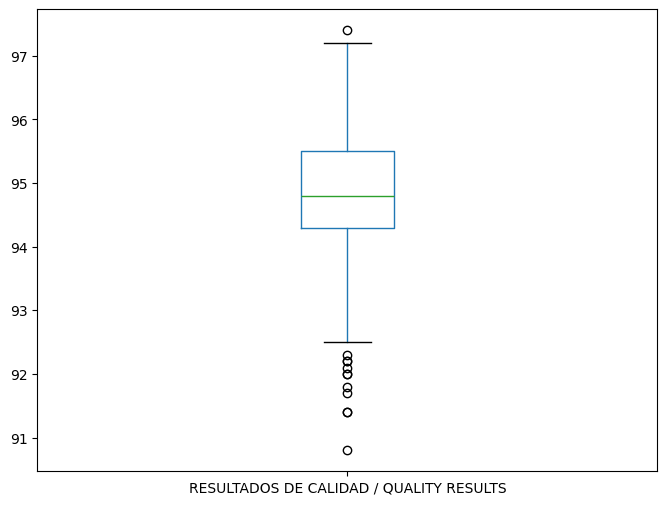

In [492]:
boxplot = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')].boxplot(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

A continuación se muestran los valores atípicos identificados en el diagrama de caja anterior

In [493]:
Q1 = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.25)
Q3 = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON') & ((premium_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] < Q1 - threshold * IQR) |(premium_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] > Q3 + threshold * IQR) )] 

In [494]:
print(outliers[outliers['ANÁLISIS / ANALYSES'].str.contains('RON')].groupby('NOMBRE ESTACION')['RESULTADOS DE CALIDAD / QUALITY RESULTS'].apply(list))

NOMBRE ESTACION
NEXT                                      [90.8]
PETRONAN                            [92.1, 91.8]
SHELL       [92.2, 92.3, 92.0, 91.4, 91.4, 97.4]
TEXACO                              [92.2, 92.0]
TOTAL                                     [91.7]
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: object


Revisando el histograma de los datos, se observa que está ligeramente sesgado a la izquierda. Este comportamiento es de esperarse por los datos atípicos en el lado izquierdo que se mostraron en la imagen anterior.

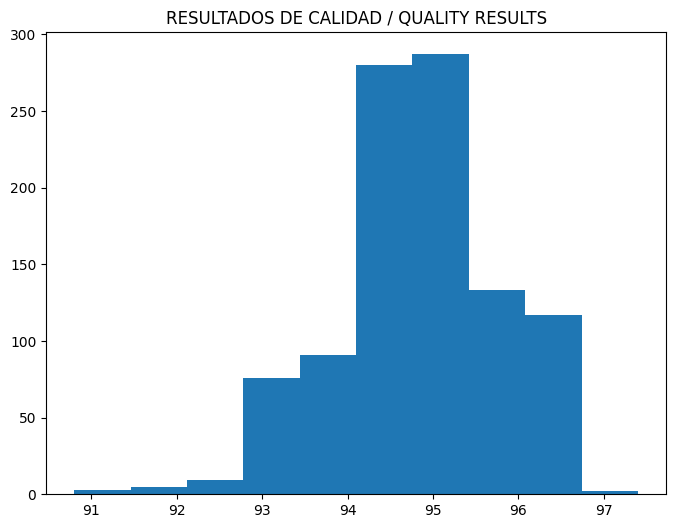

In [495]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')].hist(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

Al agrupar los datos por estación, podemos observar que las estaciones TOTAL, PETRONAN, NEXT, SOL y UNITED son las que tienen mayor variación en comparación con las demás. Los rangos de valores de estas estaciones van desde 91.7-96.6, 91.8 - 96.5, 90.8 - 96.2, 92.7 - 96.2 y 94.8 - 96.7 respectivamente, siendo NEXT la estación que obtuvo el valor mínimo más bajo (90.8).

Por otro lado, el 75% de las estaciones de AXXON, ESSO, SUNIX y TOTAL tienen un RON por debajo de 95. Por último, solo las estaciones PETROMOVIL, SHELL, TDC y ECOPETROLEO son las que tienen una mediana igual o mayor a 95, lo que indica que el 50% de sus estaciones tienen un RON de 95 o más. En el caso particular de TDC, esta fue la estación con el número mínimo más alto (95.9)

Por último, importante mencionar que el número total de estaciones AXXON, ESSO, SITRAS, TDC y UNITED es menor a 10 en cada una de ellas.

In [496]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')].groupby('NOMBRE ESTACION')['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

,count,mean,std,min,25%,50%,75%,max
NOMBRE ESTACION,,,,,,,,
ATLANTIC,13.0,94.823077,0.909353,93.5,94.100,94.80,95.400,96.3
AXXON,6.0,94.650000,0.432435,94.1,94.325,94.70,94.925,95.2
ECOPETROLEO,144.0,95.176389,0.697647,93.4,94.700,95.10,95.500,96.6
ESSO,5.0,94.440000,0.814248,93.5,93.900,94.40,94.800,95.6
EXCOM,42.0,94.964286,0.831930,92.7,94.500,94.90,95.750,96.3
NATIVA,40.0,95.950000,0.432642,94.7,95.900,96.10,96.300,96.6
NEXT,27.0,94.166667,1.192928,90.8,93.250,94.40,95.000,96.2
PETROMOVIL,34.0,95.220588,0.739279,94.2,94.725,95.00,95.925,96.7
PETRONAN,76.0,94.493421,1.043626,91.8,94.000,94.50,95.125,96.5


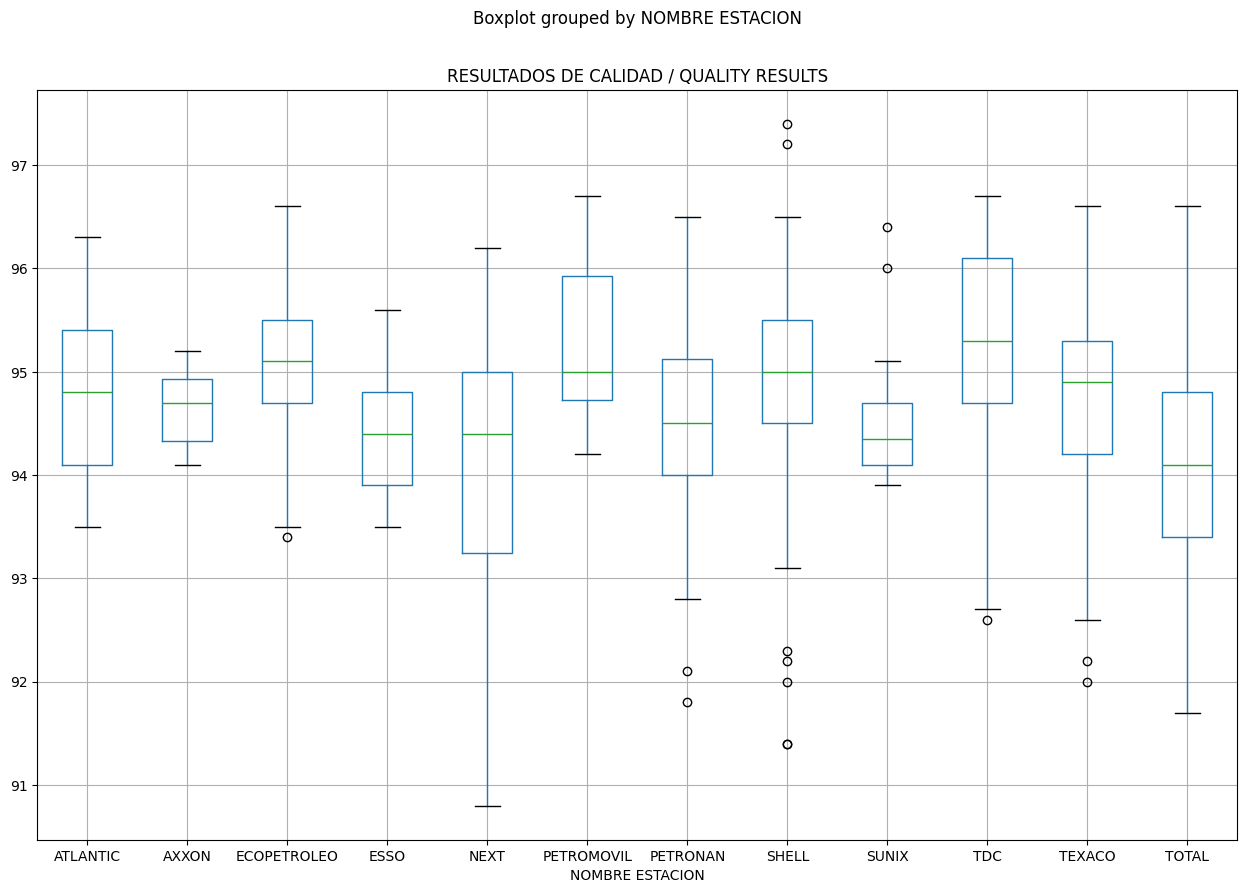

In [478]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('RON')].boxplot(
    by='NOMBRE ESTACION',
    column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS',
    figsize=(15,10))
plt.show()

Ahora pasamos al análisis de los resultados para el método MON. Como se muestra a continuación, tanto la desviación estándar como el rango es muy similar a los resultados obtenidos por el método RON, lo que sugiere poca variación en los resultados.

In [498]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

count    991.000000
mean      85.854995
std        1.113241
min       81.800000
25%       85.300000
50%       85.800000
75%       86.400000
max       88.500000
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: float64

Revisando el diagrama de caja, se muestra una forma ligeramente más simétrica en comparación con los resultados del método RON, aunque si se destaca mayor número de valores atípicos. Lo anterior también puede confirmarse observando el histograma que se muestra más debajo.

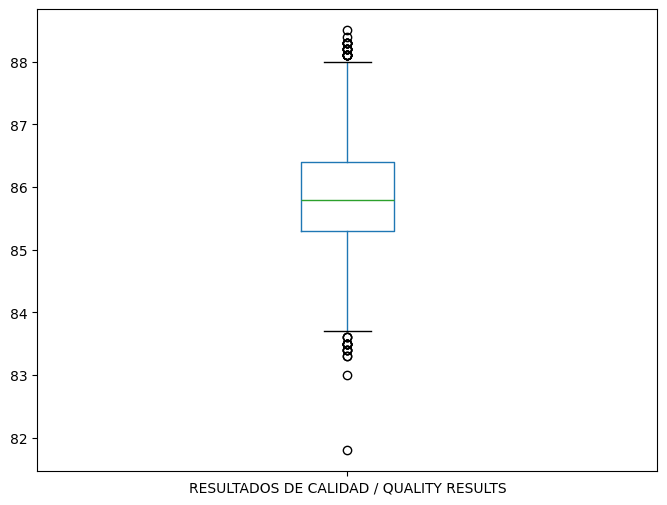

In [499]:
boxplot = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')].boxplot(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

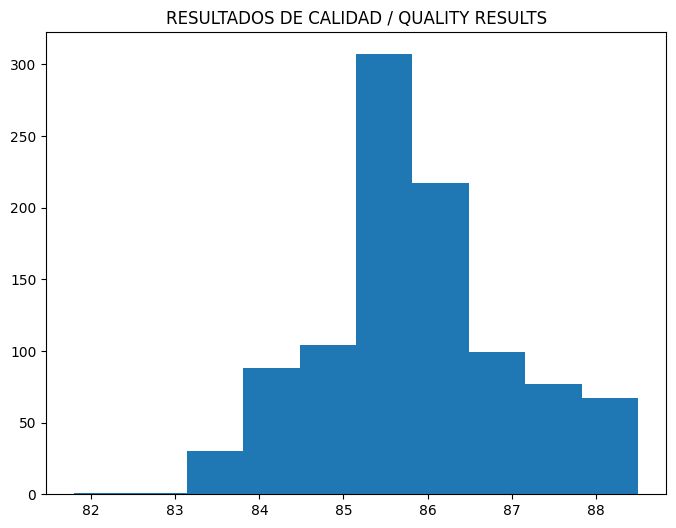

In [506]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')].hist(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

Como se mencionó arriba, en el caso del método MON, se puede apreciar un mayor número de valores atípicos. Además de las estaciones NEXT, PETRONAN, SHELL, TEXACO y TOTAL, también tienen valores atípicos las estaciones ECOPETROLEO, NATIVA, PETROMOVIL y SIGMA.

In [502]:
Q1 = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.25)
Q3 = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON') & ((premium_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] < Q1 - threshold * IQR) |(premium_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] > Q3 + threshold * IQR) )] 

In [503]:
print(outliers[outliers['ANÁLISIS / ANALYSES'].str.contains('MON')].groupby('NOMBRE ESTACION')['RESULTADOS DE CALIDAD / QUALITY RESULTS'].apply(list))

NOMBRE ESTACION
ECOPETROLEO    [88.1, 88.1, 88.3, 88.1, 88.1, 88.2, 88.1, 88....
NATIVA                                        [88.3, 88.1, 88.2]
NEXT                        [83.5, 83.4, 83.4, 83.4, 83.5, 83.0]
PETROMOVIL                        [88.5, 88.3, 88.3, 88.3, 88.2]
PETRONAN                                [88.1, 83.5, 83.5, 83.6]
SHELL                                               [83.5, 81.8]
SIGMA                                                     [88.1]
TEXACO                                              [88.2, 83.6]
TOTAL          [83.4, 83.3, 83.6, 88.2, 83.5, 83.3, 88.4, 88....
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: object


Realizando el análisis por tipo de estación se puede apreciar que todas las estaciones, a excepción de la SHELL, tienen sus valores por encima de 82, el cual es el valor de referencia mínimo. En cuanto a dispersión de lso datos, las estaciones ATLANTIC, ESSO, NEXT, PETRONAN, TOTAL y UNITED son las que tienen las desviaciones estándares más altas, con un valor igual o mayor a 1.

In [504]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')].groupby('NOMBRE ESTACION')['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

,count,mean,std,min,25%,50%,75%,max
NOMBRE ESTACION,,,,,,,,
ATLANTIC,13.0,85.753846,1.023568,84.5,84.900,85.60,86.200,87.7
AXXON,6.0,85.733333,0.344480,85.2,85.525,85.90,85.975,86.0
ECOPETROLEO,143.0,86.401399,0.891587,84.7,85.800,86.20,86.700,88.3
ESSO,4.0,85.375000,1.030776,84.0,85.125,85.50,85.750,86.5
EXCOM,44.0,85.797727,0.975631,83.8,85.200,85.60,86.400,88.0
NATIVA,39.0,87.474359,0.627744,85.9,87.500,87.70,87.900,88.3
NEXT,26.0,85.169231,1.351079,83.0,84.050,85.50,86.075,88.0
PETROMOVIL,34.0,86.505882,0.990238,85.5,85.800,86.10,87.225,88.5
PETRONAN,75.0,85.628000,1.152853,83.5,84.850,85.60,86.150,88.1


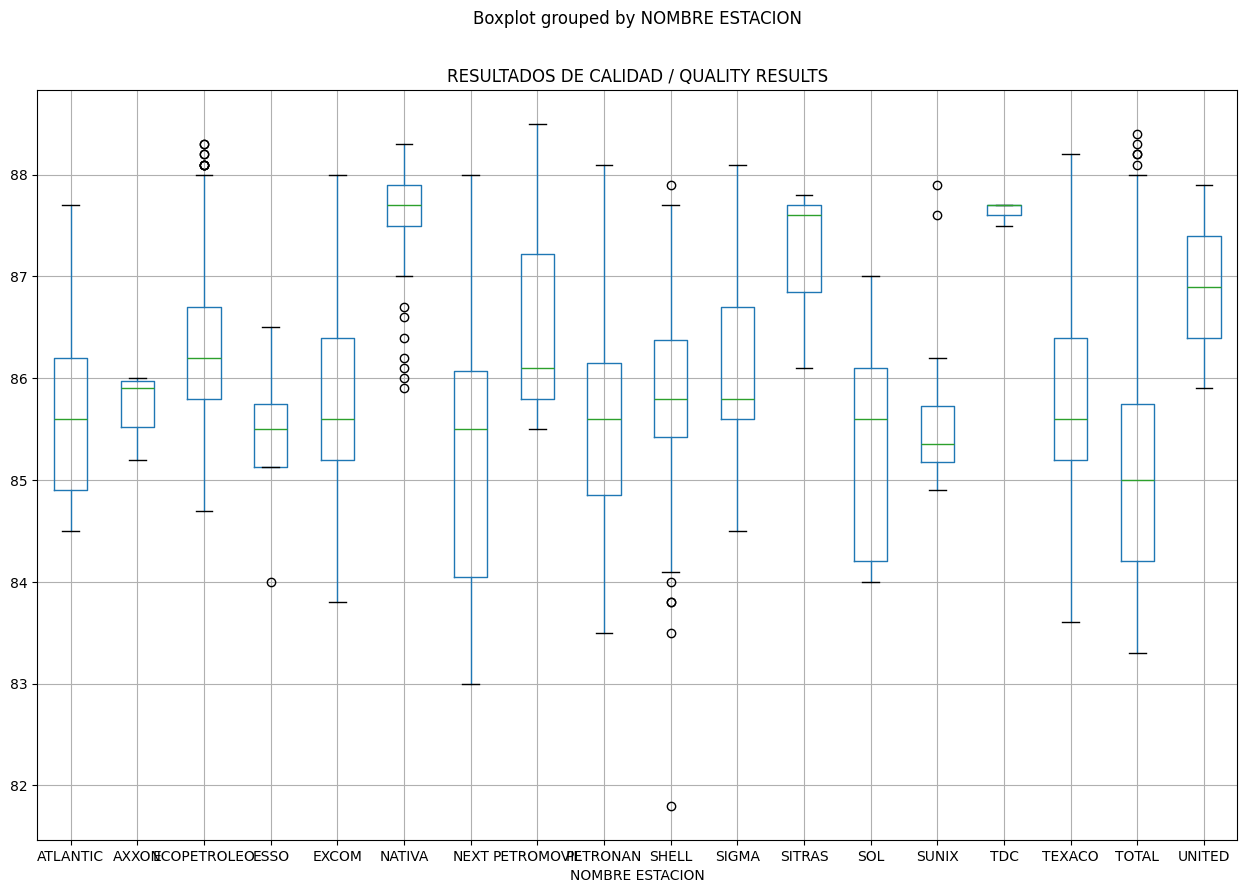

In [505]:
premium_df[premium_df['ANÁLISIS / ANALYSES'].str.contains('MON')].boxplot(
    by='NOMBRE ESTACION',
    column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS',
    figsize=(15,10))
plt.show()

#### **3.3. Análisis Gasolina Regular**

Ahora procederemos a realizar el análisis descriptivo para la gasolina de tipo regular. Para esto, creamos primero un dataframe que contenga solo los valores de la gasolina de este tipo.

In [507]:
regular_df = df_ron_mon[df_ron_mon['PRODUCTO'].str.contains('REGULAR')]

Revisando los resultados por el método RON, se aprecia que el 75% de los datos se encuentran por encima del valor 90.4, superior al mínimo de referencia el cual es 89.

In [515]:
regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

count    892.000000
mean      91.555381
std        1.721562
min       83.800000
25%       90.400000
50%       91.800000
75%       92.400000
max       98.600000
Name: RESULTADOS DE CALIDAD / QUALITY RESULTS, dtype: float64

En el diagrama de caja se puede visualizar menor presencia de valores atípicos, mientras que en el histograma se muestra una distribución centrada. Sin embargo, llama la atención que la mayoría de los valores atípicos se encuentran en el extremo derecho, es decir, con valores que rondan en 95 o más.

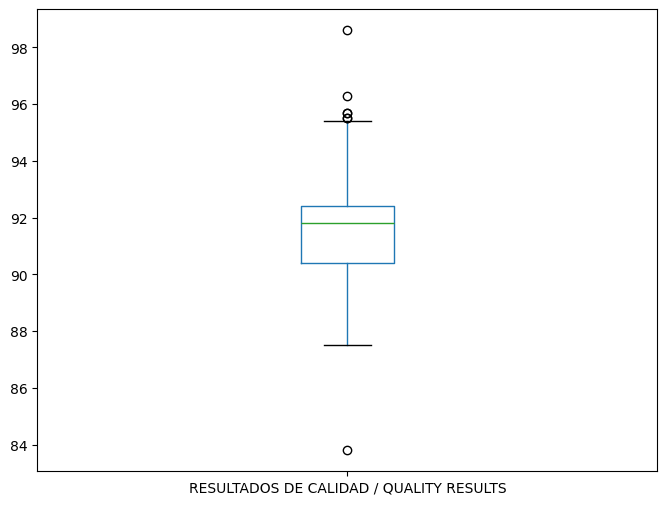

In [508]:
boxplot = regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')].boxplot(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

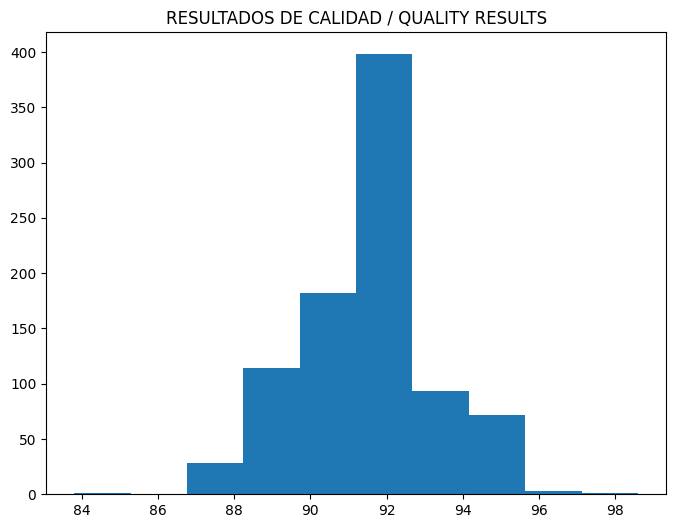

In [512]:
regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')].hist(column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS', figsize=(8,6), grid=False)
plt.show()

Revisando un poco más de cerca los atípicos, se evidencian valores muy por encima del valor mínimo de referencia, el cual es 89. Por ejemplo, TOTAL las Hortensias y SHELL Alvarez presentan valores de 98.6 y 96.3 respectivamente, incluso superior al valor mínimo de referencia de la gasolina Premium.

Estos valores fueron confirmados en el reporte original para descartar cualquier error durante el preprocesamiento de los datos.

In [513]:
Q1 = regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.25)
Q3 = regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')]['RESULTADOS DE CALIDAD / QUALITY RESULTS'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5

outliers = regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON') & ((regular_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] < Q1 - threshold * IQR) |(regular_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] > Q3 + threshold * IQR) )] 

In [531]:
outliers [['CLIENTE', 'RESULTADOS DE CALIDAD / QUALITY RESULTS', 'ARCHIVO']]

,CLIENTE,RESULTADOS DE CALIDAD / QUALITY RESULTS,ARCHIVO
5324,TOTAL HACIENDA,83.8,2023 05 114.pdf
7596,PETROMOVIL JHL HAINA,95.5,2023 02 046.pdf
9026,TOTAL LAS HORTENSIAS,98.6,2023 01 025.pdf
9355,TOTAL LA 27 DE FEBRERO,95.7,2023 03 068.pdf
10051,SHELL ALVAREZ,96.3,2023 07 129.pdf
22713,TOTAL LA ESTRELLA,95.7,2023 02 076.pdf
29123,ECOPETROLEO CAMILO,95.5,2023 05 137.pdf


Realizando el análisis para cada estación, se evidencia que para las estaciones ATLANTIC y SOL cerca del 25% de los resultados caen por debajo de 89. Para las demás, el 75% de los datos son iguales o mayores al valor mínimo de referencia, el cual es de 89.

In [534]:
regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')].groupby('NOMBRE ESTACION')['RESULTADOS DE CALIDAD / QUALITY RESULTS'].describe()

,count,mean,std,min,25%,50%,75%,max
NOMBRE ESTACION,,,,,,,,
ATLANTIC,9.0,89.833333,1.081665,88.4,88.900,90.10,90.200,91.8
AXXON,6.0,94.233333,0.939503,92.9,93.650,94.30,94.950,95.3
ECOPETROLEO,119.0,92.473950,1.294150,88.5,91.800,92.20,92.550,95.5
ESSO,3.0,92.200000,0.953939,91.3,91.700,92.10,92.650,93.2
EXCOM,28.0,90.660714,1.780416,87.5,89.175,91.00,91.825,94.0
NATIVA,34.0,92.023529,0.451300,90.6,91.925,92.10,92.300,92.5
NEXT,34.0,91.158824,1.654950,88.6,90.125,90.45,92.475,94.8
PETROMOVIL,32.0,92.381250,1.126925,90.7,91.900,92.05,92.725,95.5
PETRONAN,69.0,91.889855,1.902254,87.9,90.800,91.90,93.200,95.4


Revisando más de cerca los datos para cada estación por medio del diagrama de caja, se puede apreciar un mayor número de valores atípicos en el extremo derecho, siendo estos por lo general igual o superior a 94.

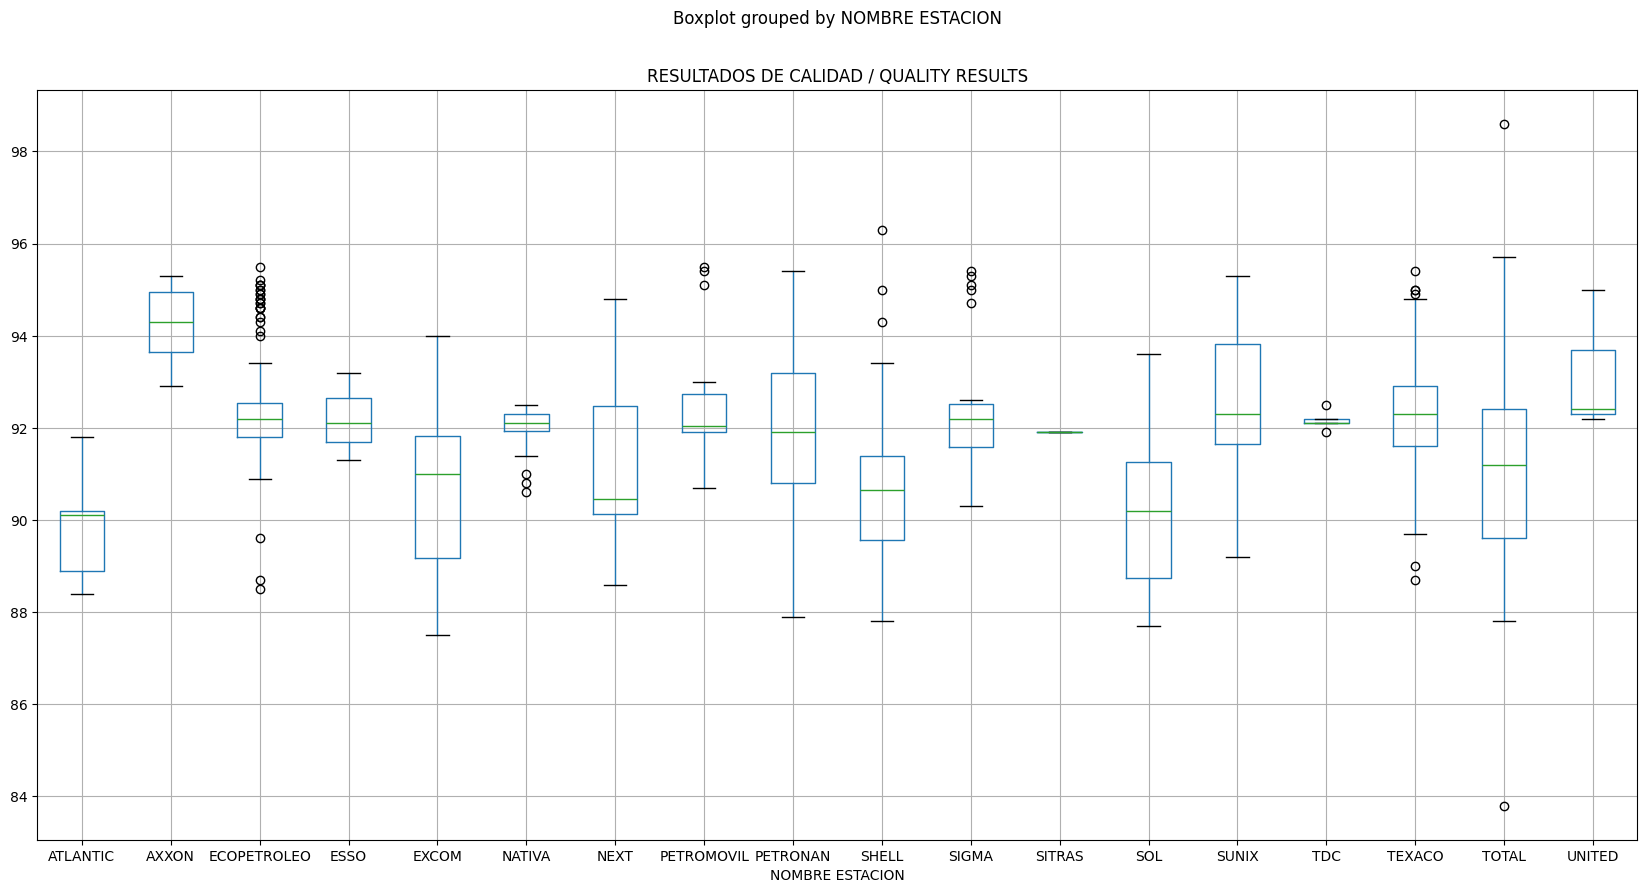

In [537]:
regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')].boxplot(
    by='NOMBRE ESTACION',
    column = 'RESULTADOS DE CALIDAD / QUALITY RESULTS',
    figsize=(20,10))
plt.show()

Filtrando todos los valores mayores o iguales a 95 del método RON para la gasolina regular, se obtienen un total de 29 registros. Como se mencionó más arriba, llama la atención que el valor obtenido en esas estaciones para la gasolina regular sea mayor o igual al valor mínimo de referencia para la gasolina premium.

In [551]:
ron_regular_df = regular_df[regular_df['ANÁLISIS / ANALYSES'].str.contains('RON')]
ron_regular_df[ron_regular_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] >= 95][['CLIENTE', 'NOMBRE ESTACION', 'ANÁLISIS / ANALYSES','RESULTADOS DE CALIDAD / QUALITY RESULTS', 'ARCHIVO']]

,CLIENTE,NOMBRE ESTACION,ANÁLISIS / ANALYSES,RESULTADOS DE CALIDAD / QUALITY RESULTS,ARCHIVO
809,TEXACO SAN ANDRES,TEXACO,NUMERO DE OCTANO METODO RESEARCH (RON),95.0,2023 02 025.pdf
4050,SIGMA AV. ECOLOGICA,SIGMA,NUMERO DE OCTANO METODO RESEARCH (RON),95.3,2023 02 037.pdf
4442,TEXACO MOCA,TEXACO,NUMERO DE OCTANO METODO RESEARCH (RON),95.4,2023 03 033.pdf
5162,SHELL JUANA RUIZ,SHELL,NUMERO DE OCTANO METODO RESEARCH (RON),95.0,2023 01 040.pdf
6065,ECOPETROLEO SATELITE,ECOPETROLEO,NUMERO DE OCTANO METODO RESEARCH (RON),95.2,2023 02 009.pdf
6087,ECOPETROLEO SATELITE,ECOPETROLEO,NUMERO DE OCTANO METODO RESEARCH (RON),95.1,2023 02 009.pdf
6364,PETROMOVIL ROMAR,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.4,2023 03 030.pdf
6387,PETROMOVIL ROMAR,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.1,2023 03 030.pdf
6876,SUNIX GENESIS,SUNIX,NUMERO DE OCTANO METODO RESEARCH (RON),95.3,2023 01 082.pdf
7596,PETROMOVIL JHL HAINA,PETROMOVIL,NUMERO DE OCTANO METODO RESEARCH (RON),95.5,2023 02 046.pdf


Realizando un conteo por estación, la estación ECOPETROLEO es la que cuenta con un mayor número de resultados igual o mayor a 95.

In [555]:
ron_regular_df[ron_regular_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] >= 95][['NOMBRE ESTACION']].value_counts()

NOMBRE ESTACION
ECOPETROLEO        7
SIGMA              4
PETROMOVIL         3
PETRONAN           3
TEXACO             3
TOTAL              3
AXXON              2
SHELL              2
SUNIX              1
UNITED             1
Name: count, dtype: int64

El número de estaciones aumenta considerablemente si se filtran los valores para un RON mayor o igual a 94.

In [556]:
ron_regular_df[ron_regular_df['RESULTADOS DE CALIDAD / QUALITY RESULTS'] >= 94][['NOMBRE ESTACION']].value_counts()

NOMBRE ESTACION
ECOPETROLEO        23
TEXACO             15
PETRONAN           14
TOTAL              13
SIGMA               5
SUNIX               4
AXXON               3
NEXT                3
PETROMOVIL          3
SHELL               3
EXCOM               1
UNITED              1
Name: count, dtype: int64

### **4. Conclusiones**

Este análisis se enfocó solamente para los valores RON de la gasolina premium y regular, así como los valores MON para la gasolina premium. Los datos utilizados fueron extraidos directamente de los informes a través del servicio Document Intelligence de Azure. Un total de 100 archivos no pudieron ser procesados, por lo que queda pendiente de su revisión para evaluar la posibilidad de resolver los errores e incorporar los datos de esos reportes al análisis.

En cuanto a los resultados del análisis, para la gasolina premium se aprecia poca variación en los datos lo que implica que su calidad es consistente. Sin embargo, para una gran cantidad de estaciones, la media se encuentra fuera del rango de los valores mínimos establecidos. Por ejemplo, para el método RON, cerca del 50% de los datos se encuentran por debajo de 95.

Respecto a la gasolina regular, también se evidencia consistencia en sus valores, aunque en menor medida. Algunos hallazgos llaman la atención, como por ejemplo el hecho de que varios resultados por el método RON se encuentran igual o por encima de 95, valor mínimo establecido para la gasolina premium.